In [1]:
%load_ext dotenv
%dotenv -o ..//.env.local

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import os
import psycopg
from psycopg.rows import dict_row

with psycopg.connect(f"host={os.getenv('PGHOST')} port={os.getenv('PGPORT')} dbname={os.getenv('PGDATABASE')} user={os.getenv('PGUSER')} password={os.getenv('PGPASSWORD')}", row_factory=dict_row) as conn:
    with conn.cursor() as cur:
        cur.execute("SELECT * FROM bidding_results WHERE month >= '2018' ORDER BY month DESC, exercise DESC, vehicle_category")
        records = cur.fetchall()
        bidding_results_raw = pd.DataFrame(records)
        cur.execute("SELECT * FROM realtime_status ORDER BY month DESC, exercise DESC, vehicle_category, timestamp DESC")
        records = cur.fetchall()
        realtime_status_raw = pd.DataFrame(records)

In [4]:
bidding_results = bidding_results_raw
bidding_results['month_exercise'] = bidding_results['month'] + '/' + bidding_results['exercise']
bidding_results = bidding_results[bidding_results['month_exercise'] >= '2018-10/2'].copy()

In [5]:
bidding_results['excess_demand'] = (bidding_results['bids_received'] - bidding_results['quota']) / bidding_results['quota']

In [6]:
bidding_results_i = bidding_results.set_index(['month', 'exercise', 'vehicle_category'])
bidding_results_i

last_updated  quota  quota_premium  \
month   exercise vehicle_category                                      
2024-12 1        A                  2024-12-05   1037        94000.0   
                 B                  2024-12-05    689       103010.0   
                 C                  2024-12-05    262        70289.0   
                 D                  2024-12-05    517         7878.0   
                 E                  2024-12-05    179       104001.0   
...                                        ...    ...            ...   
2018-10 2        A                  2018-11-05   1674        25556.0   
                 B                  2018-11-05   1273        31302.0   
                 C                  2018-11-05    350        29501.0   
                 D                  2018-11-05    819         3951.0   
                 E                  2018-11-05    539        32900.0   

                                   bids_received  bids_successful  \
month   exercise vehicle_category                                   
2024-12 1        A                        1475.0           1034.0   
                 B                         866.0            689.0   
                 C                         418.0            249.0   
                 D                         570.0            516.0   
                 E                         326.0            167.0   
...                                          ...              ...   
2018-10 2        A                        1811.0           1672.0   
                 B                        1856.0           1267.0   
                 C                         470.0            349.0   
                 D                        1201.0            819.0   
                 E                         779.0            527.0   

                                  month_exercise  excess_demand  
month   exercise vehicle_category                                
2024-12 1        A                     2024-12/1       0.422372  
                 B                     2024-12/1       0.256894  
                 C                     2024-12/1       0.595420  
                 D                     2024-12/1       0.102515  
                 E                     2024-12/1       0.821229  
...                                          ...            ...  
2018-10 2        A                     2018-10/2       0.081840  
                 B                     2018-10/2       0.457973  
                 C                     2018-10/2       0.342857  
                 D                     2018-10/2       0.466422  
                 E                     2018-10/2       0.445269  

[420 rows x 7 columns]

In [7]:
realtime_status = realtime_status_raw[realtime_status_raw['month'] != '2020-04']

realtime_status['timestamp'] = realtime_status['timestamp'].dt.tz_convert('UTC')
realtime_status['date'] = realtime_status['timestamp'].dt.date
realtime_status['time'] = realtime_status['timestamp'].dt.time
realtime_status

,timestamp,month,exercise,vehicle_category,current_bids,current_price,date,time
0,2024-12-04 07:58:44+00:00,2024-12,1,A,1475,93890,2024-12-04,07:58:44
1,2024-12-04 07:57:24+00:00,2024-12,1,A,1474,92818,2024-12-04,07:57:24
2,2024-12-04 07:56:44+00:00,2024-12,1,A,1474,92803,2024-12-04,07:56:44
3,2024-12-04 07:55:24+00:00,2024-12,1,A,1460,91890,2024-12-04,07:55:24
4,2024-12-04 07:54:44+00:00,2024-12,1,A,1431,90000,2024-12-04,07:54:44
...,...,...,...,...,...,...,...,...
319906,2018-10-15 04:15:25+00:00,2018-10,2,E,0,1,2018-10-15,04:15:25
319907,2018-10-15 04:14:05+00:00,2018-10,2,E,0,1,2018-10-15,04:14:05
319908,2018-10-15 04:13:25+00:00,2018-10,2,E,0,1,2018-10-15,04:13:25
319909,2018-10-15 04:12:45+00:00,2018-10,2,E,0,1,2018-10-15,04:12:45


In [8]:
merged_realtime_status = pd.merge(realtime_status, bidding_results, on=['month', 'exercise', 'vehicle_category'], how='left')
merged_realtime_status = merged_realtime_status.dropna(subset=['quota_premium'])

In [9]:
bidding_results_grouped_by_cat = bidding_results_i.groupby(level='vehicle_category')

pd.options.display.float_format = '{:,.0f}'.format
bidding_results_grouped_by_cat['quota_premium'].describe()

,count,mean,std,min,25%,50%,75%,max
vehicle_category,,,,,,,,
A,83,"43,546","19,493","23,568","31,771","37,334","47,910","103,799"
B,83,"53,506","23,397","30,012","37,051","42,564","61,096","116,002"
C,83,"35,758","13,255","22,002","26,116","31,502","41,350","75,009"
D,83,"6,517","2,576","2,509","3,794","7,432","8,702","11,400"
E,83,"55,069","23,916","30,851","37,994","45,510","63,851","116,000"


In [10]:
pd.options.display.float_format = '{:,.3f}'.format
bidding_results_grouped_by_cat['excess_demand'].describe()

,count,mean,std,min,25%,50%,75%,max
vehicle_category,,,,,,,,
A,83.000,0.440,0.206,0.082,0.327,0.398,0.490,1.375
B,83.000,0.446,0.217,0.143,0.293,0.420,0.554,1.448
C,83.000,0.678,0.246,0.264,0.509,0.637,0.832,1.618
D,83.000,0.340,0.112,0.103,0.264,0.324,0.394,0.854
E,83.000,0.620,0.224,0.278,0.449,0.567,0.681,1.205


In [11]:
merged_realtime_status['demand'] = merged_realtime_status['bids_received'] - (merged_realtime_status['current_bids'] - merged_realtime_status['quota'])
merged_realtime_status['reservation_price'] = merged_realtime_status['current_price'] - 1
merged_realtime_status['percent_final_price'] = merged_realtime_status['current_price'] / merged_realtime_status['quota_premium']
merged_realtime_status['percent_bids_in'] = merged_realtime_status['current_bids'] / merged_realtime_status['bids_received']

In [12]:
merged_realtime_status['time_to_closing'] = (
    pd.to_datetime(merged_realtime_status.groupby(['month', 'exercise'])['date'].transform('max')) + pd.Timedelta(hours=8)
).dt.tz_localize('UTC') - merged_realtime_status['timestamp']
merged_realtime_status['percent_to_closing'] = 1 - merged_realtime_status['time_to_closing'] / pd.Timedelta(hours=8)

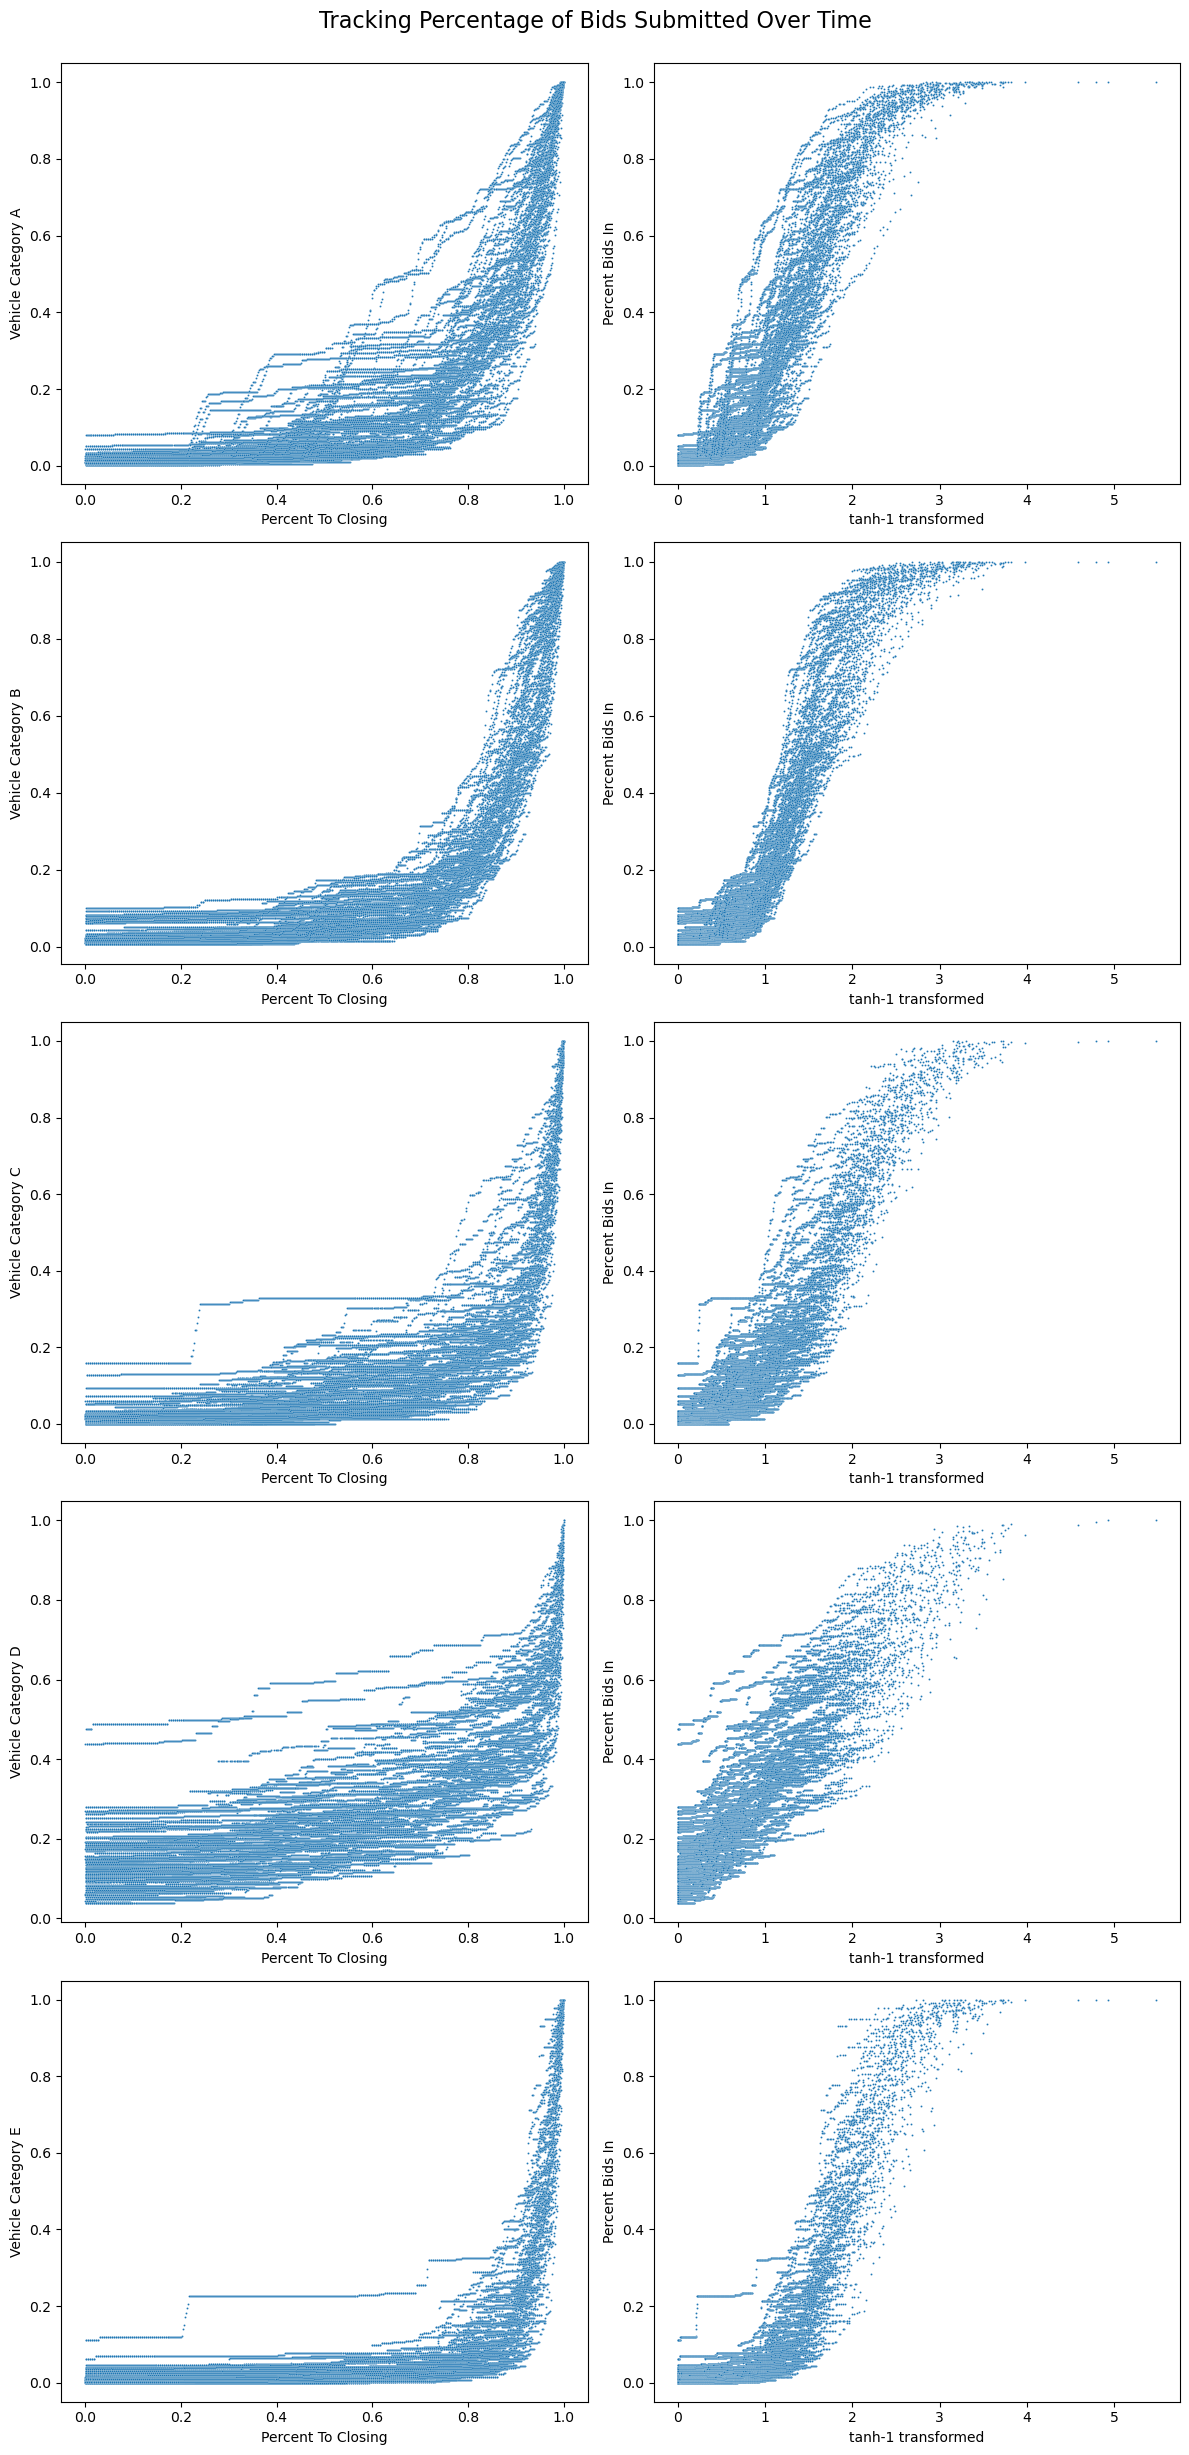

In [13]:
filtered = merged_realtime_status[(merged_realtime_status['percent_to_closing'] >= 0) & (merged_realtime_status['percent_to_closing'] < 1)].copy()
filtered['arctanh_x'] = np.arctanh(filtered['percent_to_closing'])
filtered['x'] = filtered['percent_to_closing']
filtered['y'] = filtered['percent_bids_in']

all_categories = sorted(bidding_results['vehicle_category'].unique())

fig, axes = plt.subplots(len(all_categories), 2, figsize=(12, 5 * len(all_categories)))

# Plot for each vehicle category
for i, category in enumerate(all_categories):
    category_data = filtered[filtered['vehicle_category'] == category]
    
    # Plot x/y scatter
    sns.scatterplot(data=category_data, x='x', y='y', s=2, ax=axes[i, 0])
    axes[i, 0].set_xlabel('Percent To Closing')
    axes[i, 0].set_ylabel(f'Vehicle Category {category}')
    
    
    # Plot arctanh_x/y scatter
    sns.scatterplot(data=category_data, x='arctanh_x', y='y', s=2, ax=axes[i, 1])
    axes[i, 1].set_xlabel('tanh-1 transformed')
    axes[i, 1].set_ylabel('Percent Bids In')

fig.suptitle('Tracking Percentage of Bids Submitted Over Time', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.98])

In [14]:
filtered_25 = merged_realtime_status[merged_realtime_status['percent_bids_in'] >= 0.25]
time_25_bids_in = filtered_25.groupby(['month', 'exercise', 'vehicle_category'])['percent_to_closing'].min()
time_25_bids_in.rename('time_25_bids_in', inplace=True)

filtered_50 = merged_realtime_status[merged_realtime_status['percent_bids_in'] >= 0.5]
time_50_bids_in = filtered_50.groupby(['month', 'exercise', 'vehicle_category'])['percent_to_closing'].min()
time_50_bids_in.rename('time_50_bids_in', inplace=True)

filtered_75 = merged_realtime_status[merged_realtime_status['percent_bids_in'] >= 0.75]
time_75_bids_in = filtered_75.groupby(['month', 'exercise', 'vehicle_category'])['percent_to_closing'].min()
time_75_bids_in.rename('time_75_bids_in', inplace=True)

time_percent_bids_in = time_25_bids_in.to_frame().join(time_50_bids_in).join(time_75_bids_in)

In [15]:
time_percent_bids_in = (1 - time_percent_bids_in) * 480
time_percent_bids_in.groupby(level='vehicle_category').median()

,time_25_bids_in,time_50_bids_in,time_75_bids_in
vehicle_category,,,
A,100.717,45.650,19.283
B,83.633,44.400,20.650
C,58.900,23.533,7.600
D,200.500,31.100,5.050
E,37.600,17.683,7.733


In [16]:
time_percent_bids_in.groupby(level='vehicle_category')['time_50_bids_in'].describe()

,count,mean,std,min,25%,50%,75%,max
vehicle_category,,,,,,,,
A,83.000,52.315,26.855,13.883,34.642,45.650,63.142,160.333
B,83.000,46.034,14.976,14.500,35.033,44.400,54.358,81.800
C,83.000,27.512,17.573,8.067,17.633,23.533,29.425,106.183
D,83.000,53.969,59.591,5.033,20.158,31.100,72.442,343.800
E,83.000,19.889,8.585,5.267,13.475,17.683,25.783,39.750


In [17]:
filtered_25 = merged_realtime_status[merged_realtime_status['percent_final_price'] >= 0.25]
time_25_final_price = filtered_25.groupby(['month', 'exercise', 'vehicle_category'])['percent_to_closing'].min()
time_25_final_price.rename('time_25_final_price', inplace=True)

filtered_50 = merged_realtime_status[merged_realtime_status['percent_final_price'] >= 0.5]
time_50_final_price = filtered_50.groupby(['month', 'exercise', 'vehicle_category'])['percent_to_closing'].min()
time_50_final_price.rename('time_50_final_price', inplace=True)

filtered_75 = merged_realtime_status[merged_realtime_status['percent_final_price'] >= 0.75]
time_75_final_price = filtered_75.groupby(['month', 'exercise', 'vehicle_category'])['percent_to_closing'].min()
time_75_final_price.rename('time_75_final_price', inplace=True)

time_percent_final_price = time_25_final_price.to_frame().join(time_50_final_price).join(time_75_final_price)

In [18]:
time_percent_final_price = (1 - time_percent_final_price) * 480
time_percent_final_price.groupby(level='vehicle_category').median()

,time_25_final_price,time_50_final_price,time_75_final_price
vehicle_category,,,
A,21.083,20.350,17.067
B,22.900,22.900,22.400
C,15.267,15.133,13.383
D,4.517,4.275,3.958
E,11.567,10.350,9.750


In [19]:
time_percent_final_price.groupby(level='vehicle_category')['time_50_final_price'].describe()

,count,mean,std,min,25%,50%,75%,max
vehicle_category,,,,,,,,
A,83.000,28.548,26.553,2.550,13.250,20.350,34.017,142.500
B,83.000,27.937,18.701,2.900,13.025,22.900,38.900,76.467
C,83.000,19.496,15.714,2.600,9.425,15.133,25.517,95.517
D,80.000,10.846,33.078,0.000,2.550,4.275,8.537,294.467
E,83.000,12.773,7.420,1.567,7.650,10.350,15.775,37.733


In [20]:
bidding_results_i = bidding_results_i.join(time_percent_bids_in).join(time_percent_final_price)

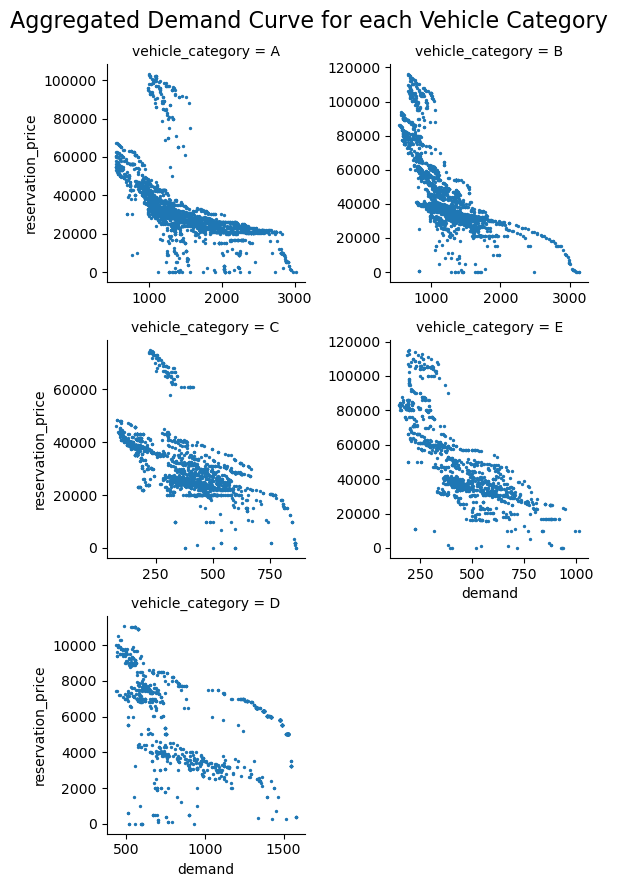

In [21]:
filtered = merged_realtime_status[merged_realtime_status['reservation_price'] > 0]
g = sns.FacetGrid(filtered, col='vehicle_category', col_wrap=2, sharex=False, sharey=False)
g.map(plt.scatter, 'demand', 'reservation_price', s = 2)
g.fig.suptitle('Aggregated Demand Curve for each Vehicle Category', fontsize=16)
g.tight_layout();

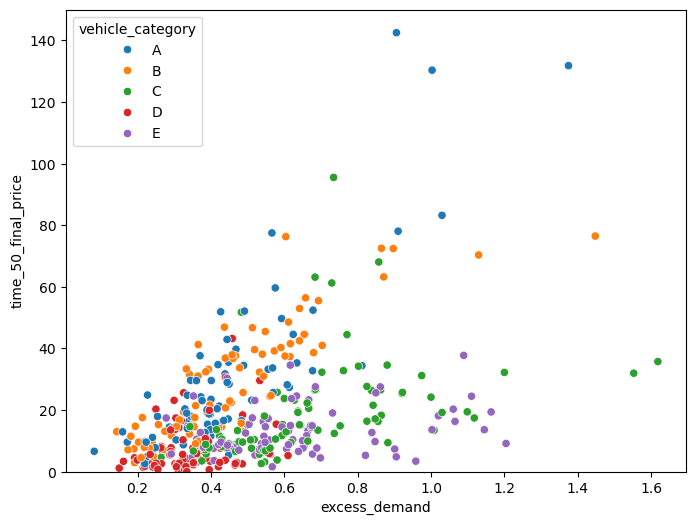

In [22]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=bidding_results_i, x='excess_demand', y='time_50_final_price', hue='vehicle_category')
plt.ylim(0, 150);

In [23]:
filtered = merged_realtime_status[merged_realtime_status['current_bids'] >= 1.2 * merged_realtime_status['quota']]
opening_price = filtered.groupby(['month', 'exercise', 'vehicle_category'])['current_price'].min().rename('opening_price').to_frame()
bidding_results_i = bidding_results_i.join(opening_price)
bidding_results_i['open_close_gap'] = 1 - bidding_results_i['opening_price'] / bidding_results_i['quota_premium']

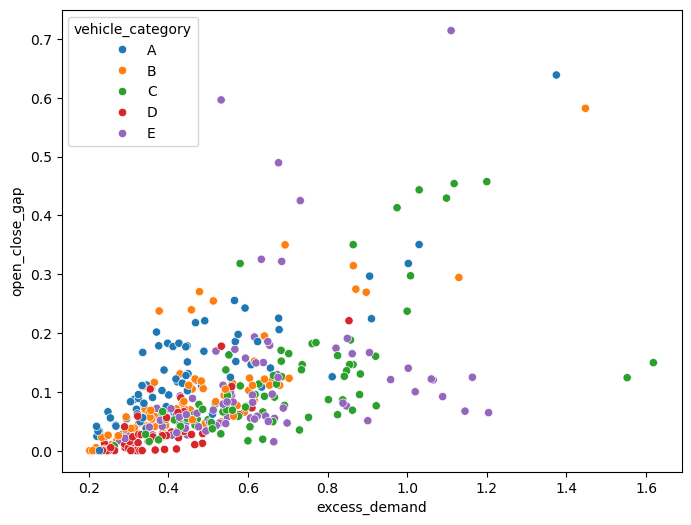

In [24]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=bidding_results_i, x='excess_demand', y='open_close_gap', hue='vehicle_category');

In [25]:
def fit_curve(group):
    y = group['reservation_price']
    x = group['demand']
    
    coefficients = np.polyfit(x * x, y * y, 1)
    return pd.Series(coefficients, index=['a', 'b'])

filtered = merged_realtime_status[merged_realtime_status['percent_final_price'] >= 0.3]
filtered = filtered.drop_duplicates(subset=['month', 'exercise', 'vehicle_category', 'reservation_price', 'demand'])
filtered = filtered.groupby(['month', 'exercise', 'vehicle_category']).filter(lambda x: len(x) >= 5)
fitted_coefficients = filtered.groupby(['month', 'exercise', 'vehicle_category']).apply(fit_curve, include_groups=False)

In [26]:
bidding_results_i['y_hat_0'] = np.sqrt(fitted_coefficients['a'] * bidding_results_i['quota'] ** 2 + fitted_coefficients['b'])
bidding_results_i['y_hat_1'] = np.sqrt(fitted_coefficients['a'] * bidding_results_i['bids_received'] ** 2 + fitted_coefficients['b'])
bidding_results_i['elasticity'] = bidding_results_i['y_hat_0'] ** 2 / bidding_results_i['quota'] ** 2 / fitted_coefficients['a']
bidding_results_i['max_p'] = np.sqrt(fitted_coefficients['b'])
bidding_results_i['max_q'] = np.sqrt(-fitted_coefficients['b'] / fitted_coefficients['a'])
bidding_results = bidding_results_i.reset_index()

/opt/miniconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [27]:
bidding_results_grouped_by_cat = bidding_results_i.groupby(level='vehicle_category')
bidding_results_grouped_by_cat['elasticity'].describe()

,count,mean,std,min,25%,50%,75%,max
vehicle_category,,,,,,,,
A,82.000,-2.134,1.211,-6.701,-2.699,-1.850,-1.395,-0.217
B,82.000,-2.431,1.377,-5.538,-3.516,-2.081,-1.287,-0.558
C,82.000,-4.576,3.336,-22.377,-4.974,-3.785,-2.779,-1.344
D,37.000,-2.278,1.390,-8.819,-2.851,-2.167,-1.477,-0.694
E,78.000,-4.473,3.711,-17.214,-5.411,-2.958,-2.119,-1.315


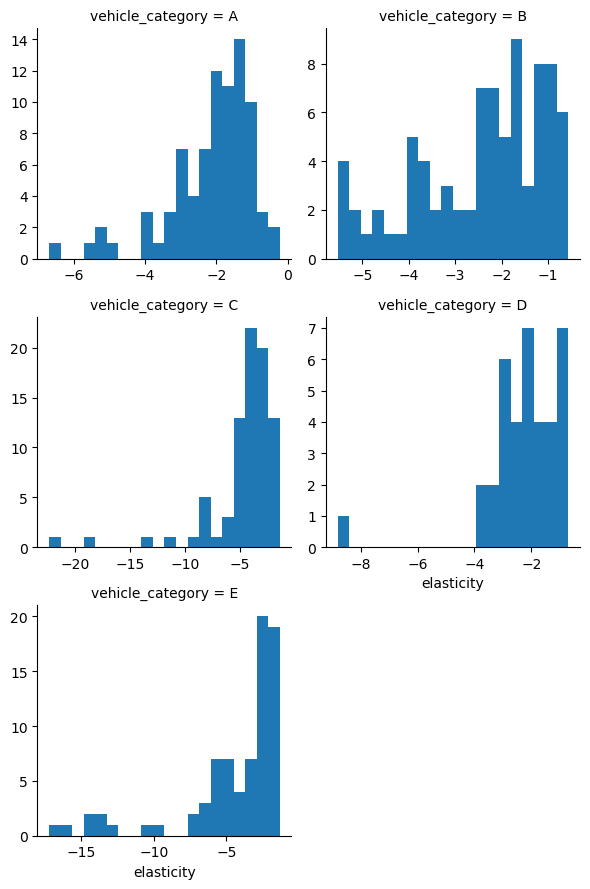

In [28]:
g = sns.FacetGrid(bidding_results, col='vehicle_category', col_wrap=2, sharex=False, sharey=False)
g.map(plt.hist, 'elasticity', bins=20);

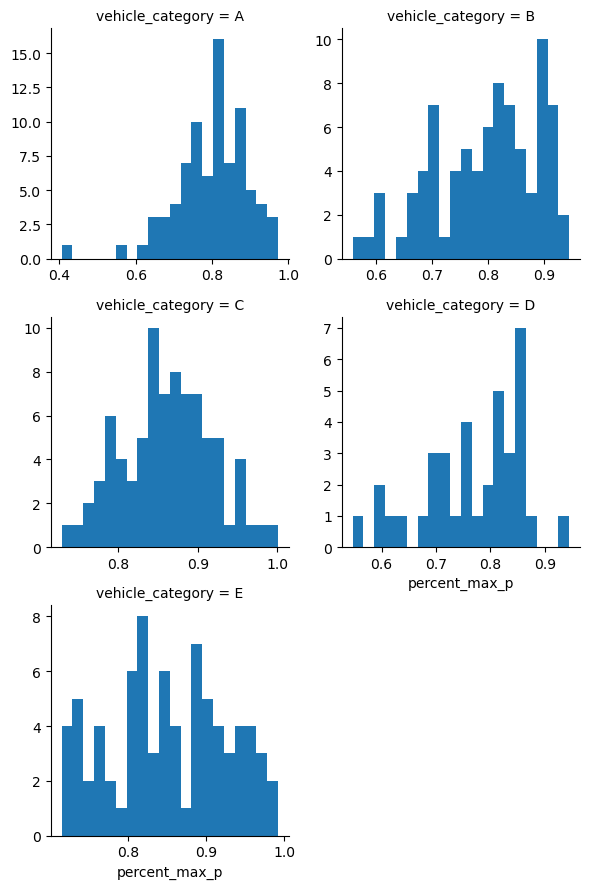

In [29]:
bidding_results_i['percent_max_p'] = bidding_results_i['quota_premium'] / bidding_results_i['max_p']

g = sns.FacetGrid(bidding_results_i.reset_index(), col='vehicle_category', col_wrap=2, sharex=False, sharey=False)
g.map(plt.hist, 'percent_max_p', bins=20);

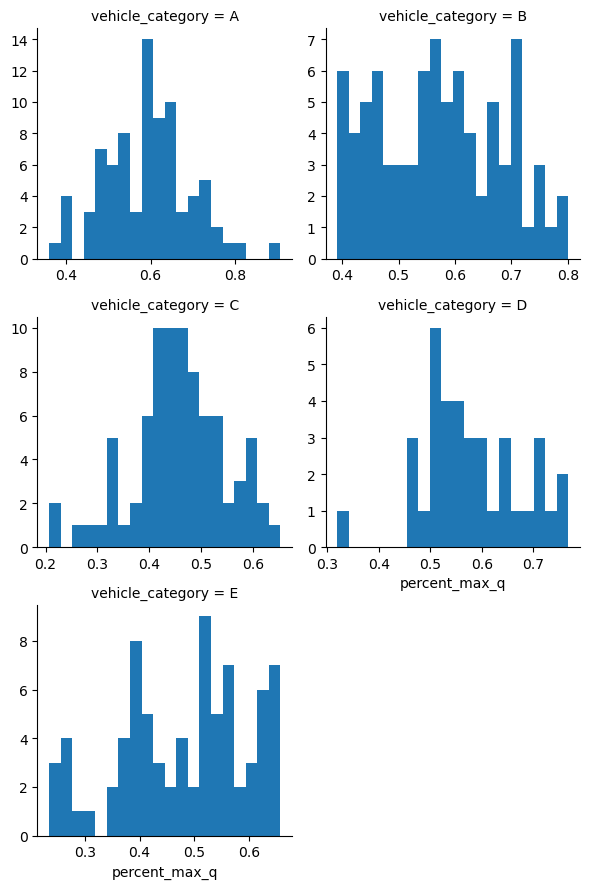

In [30]:
bidding_results_i['percent_max_q'] = bidding_results_i['quota'] / bidding_results_i['max_q']

g = sns.FacetGrid(bidding_results_i.reset_index(), col='vehicle_category', col_wrap=2, sharex=False, sharey=False)
g.map(plt.hist, 'percent_max_q', bins=20);

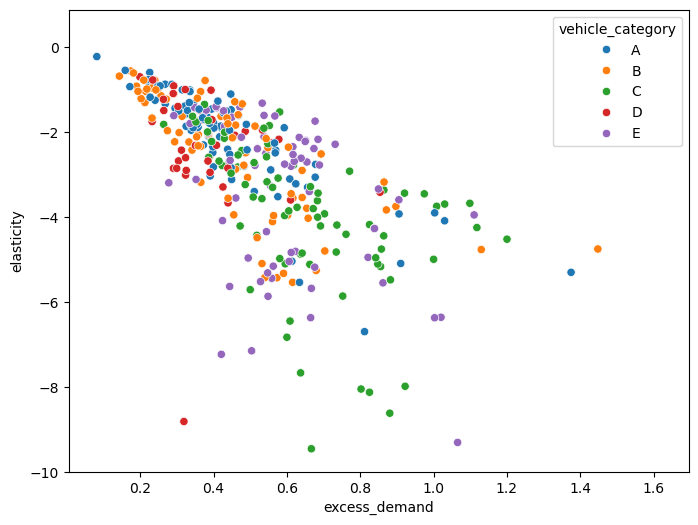

In [31]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=bidding_results, y='elasticity', x='excess_demand', hue='vehicle_category')
plt.ylim(-10, None);

In [32]:
bidding_results_i['open_close_gap'].groupby(level='vehicle_category').describe()

,count,mean,std,min,25%,50%,75%,max
vehicle_category,,,,,,,,
A,80.000,0.125,0.093,0.000,0.059,0.104,0.177,0.639
B,76.000,0.099,0.098,0.000,0.043,0.071,0.116,0.582
C,83.000,0.118,0.104,0.008,0.054,0.080,0.146,0.457
D,58.000,0.031,0.044,0.000,0.002,0.015,0.032,0.221
E,83.000,0.111,0.119,0.015,0.049,0.072,0.125,0.714


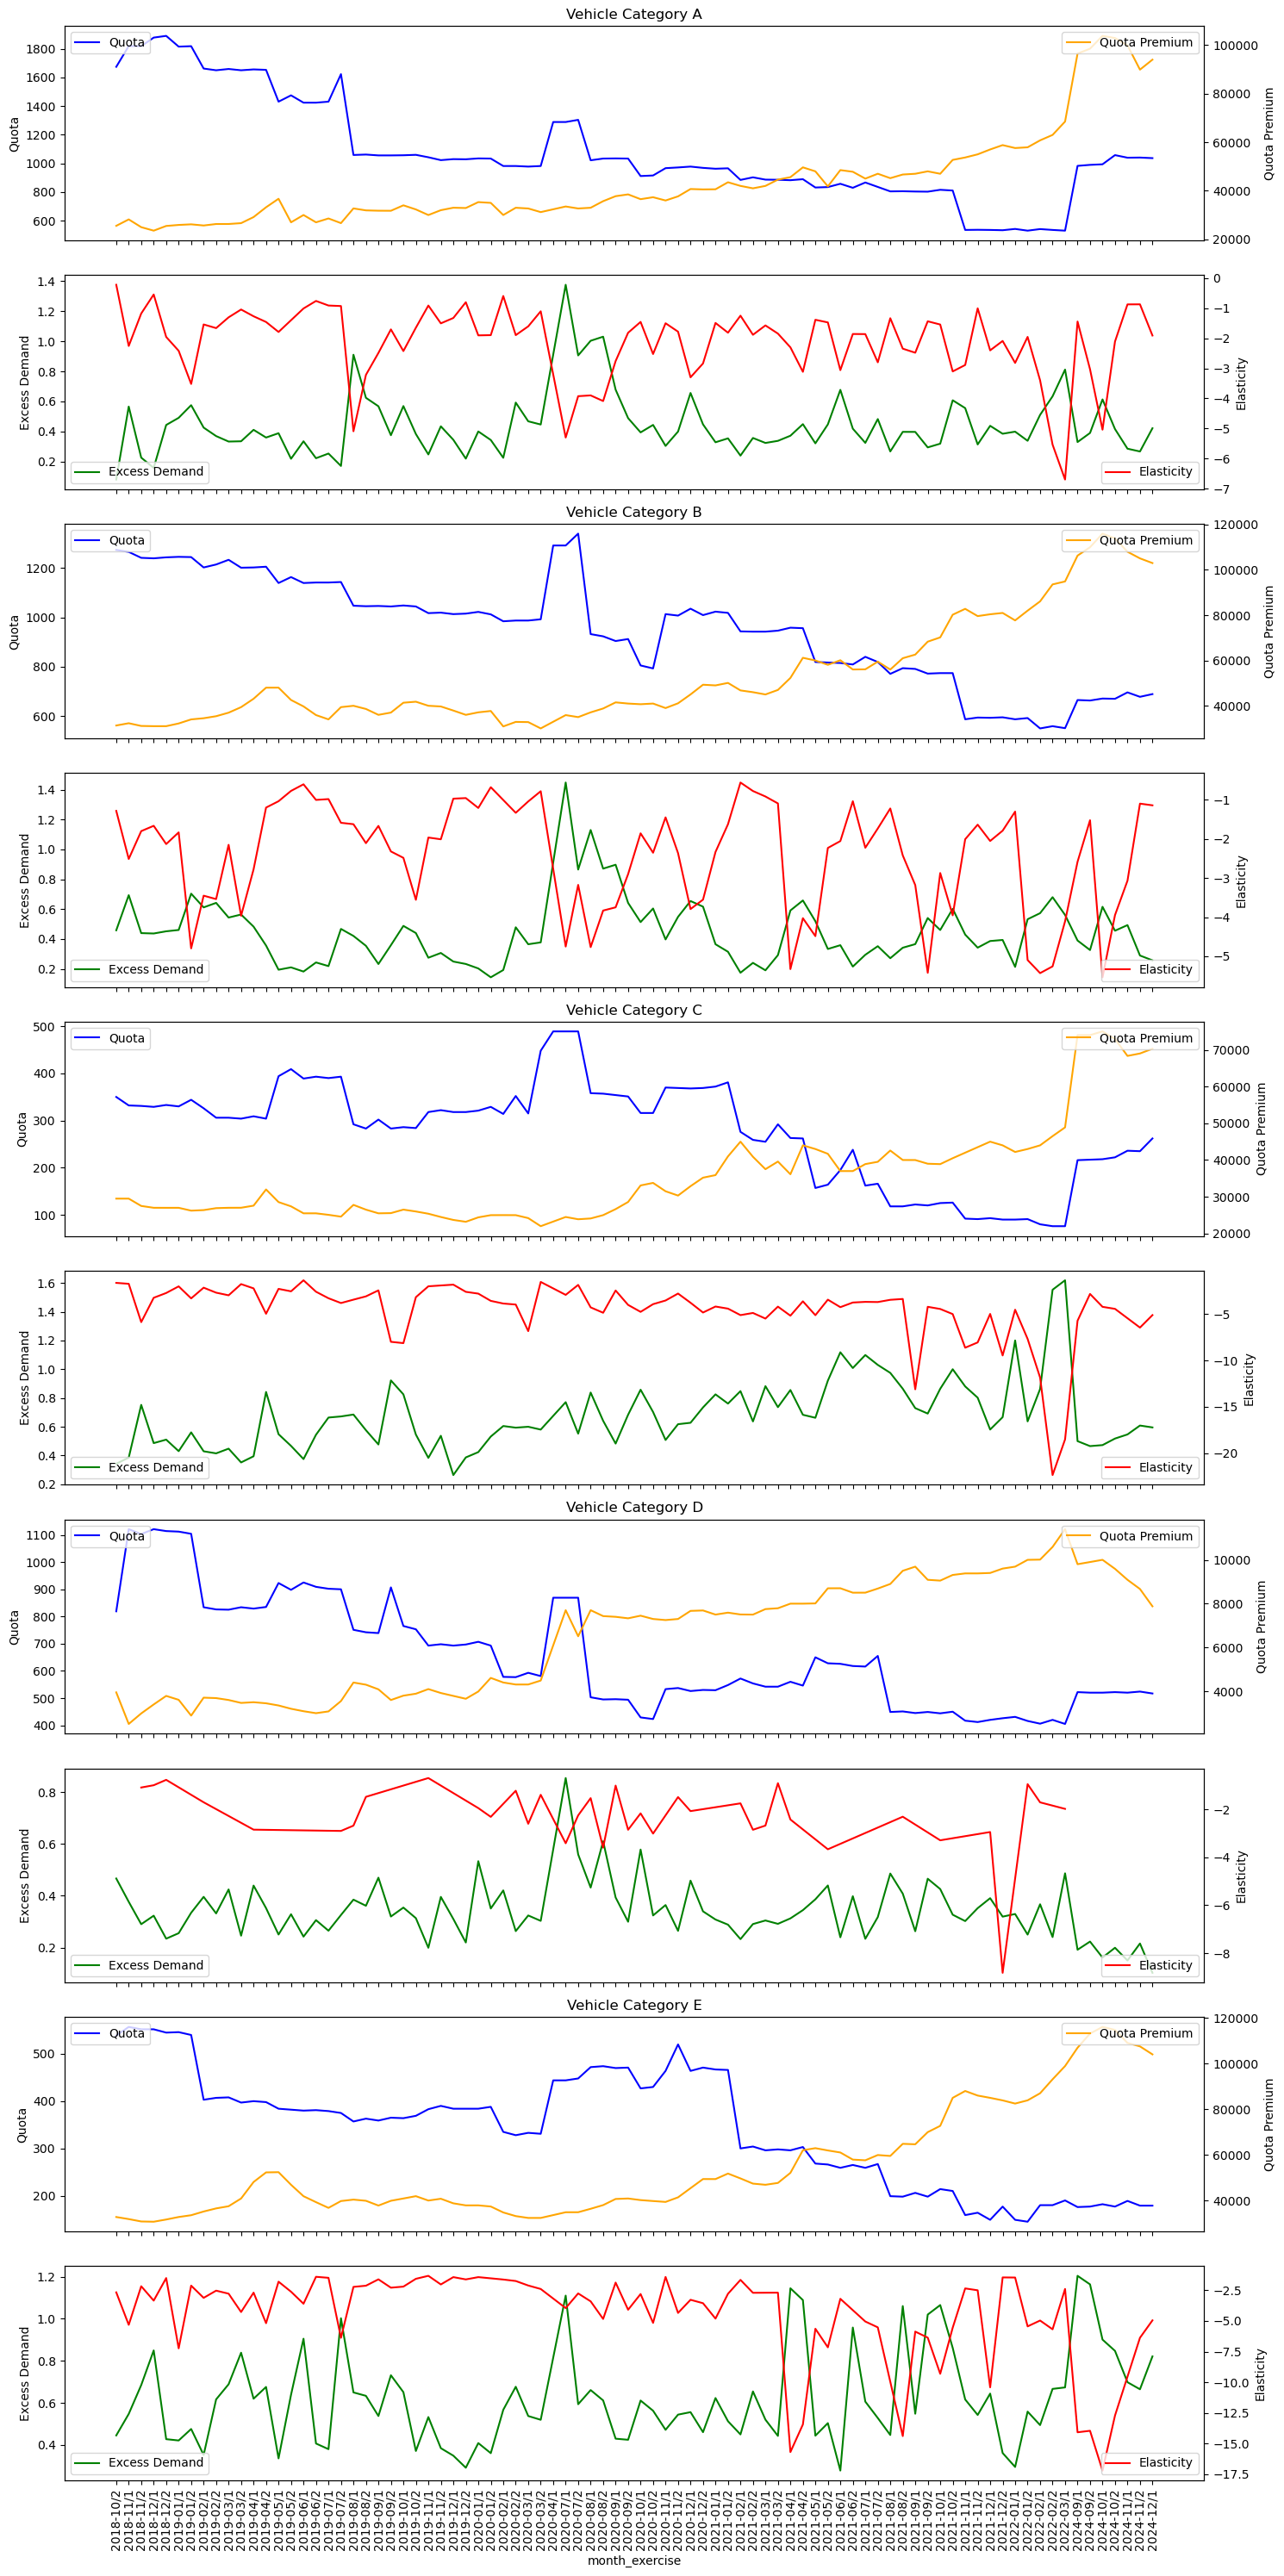

In [33]:
bidding_results_sorted = bidding_results.sort_values(['month_exercise', 'vehicle_category'])

# Get unique vehicle categories
all_categories = sorted(bidding_results['vehicle_category'].unique())

# Create subplots
fig, axes = plt.subplots(nrows=10, figsize=(15, 30), sharex='col')

# Plot each vehicle category in its own column
for i, category in enumerate(all_categories):
    data = bidding_results_sorted[bidding_results_sorted['vehicle_category'] == category]
    
    # Top facet: quota and quota_premium
    ax1 = axes[2 * i]
    ax2 = ax1.twinx()
    sns.lineplot(data=data, x='month_exercise', y='quota', label='Quota', color='blue', ax=ax1)
    sns.lineplot(data=data, x='month_exercise', y='quota_premium', label='Quota Premium', color='orange', ax=ax2)
    ax1.set_title(f'Vehicle Category {category}')
    ax1.set_ylabel('Quota')
    ax2.set_ylabel('Quota Premium')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    
    # Bottom facet: excess_demand and elasticity
    ax3 = axes[2 * i + 1]
    ax4 = ax3.twinx()
    sns.lineplot(data=data, x='month_exercise', y='excess_demand', label='Excess Demand', color='green', ax=ax3)
    sns.lineplot(data=data, x='month_exercise', y='elasticity', label='Elasticity', color='red', ax=ax4)
    ax3.set_ylabel('Excess Demand')
    ax4.set_ylabel('Elasticity')
    ax3.legend(loc='lower left')
    ax4.legend(loc='lower right')

for ax in axes:
    for label in ax.get_xticklabels():
        label.set_rotation(90)

plt.tight_layout()

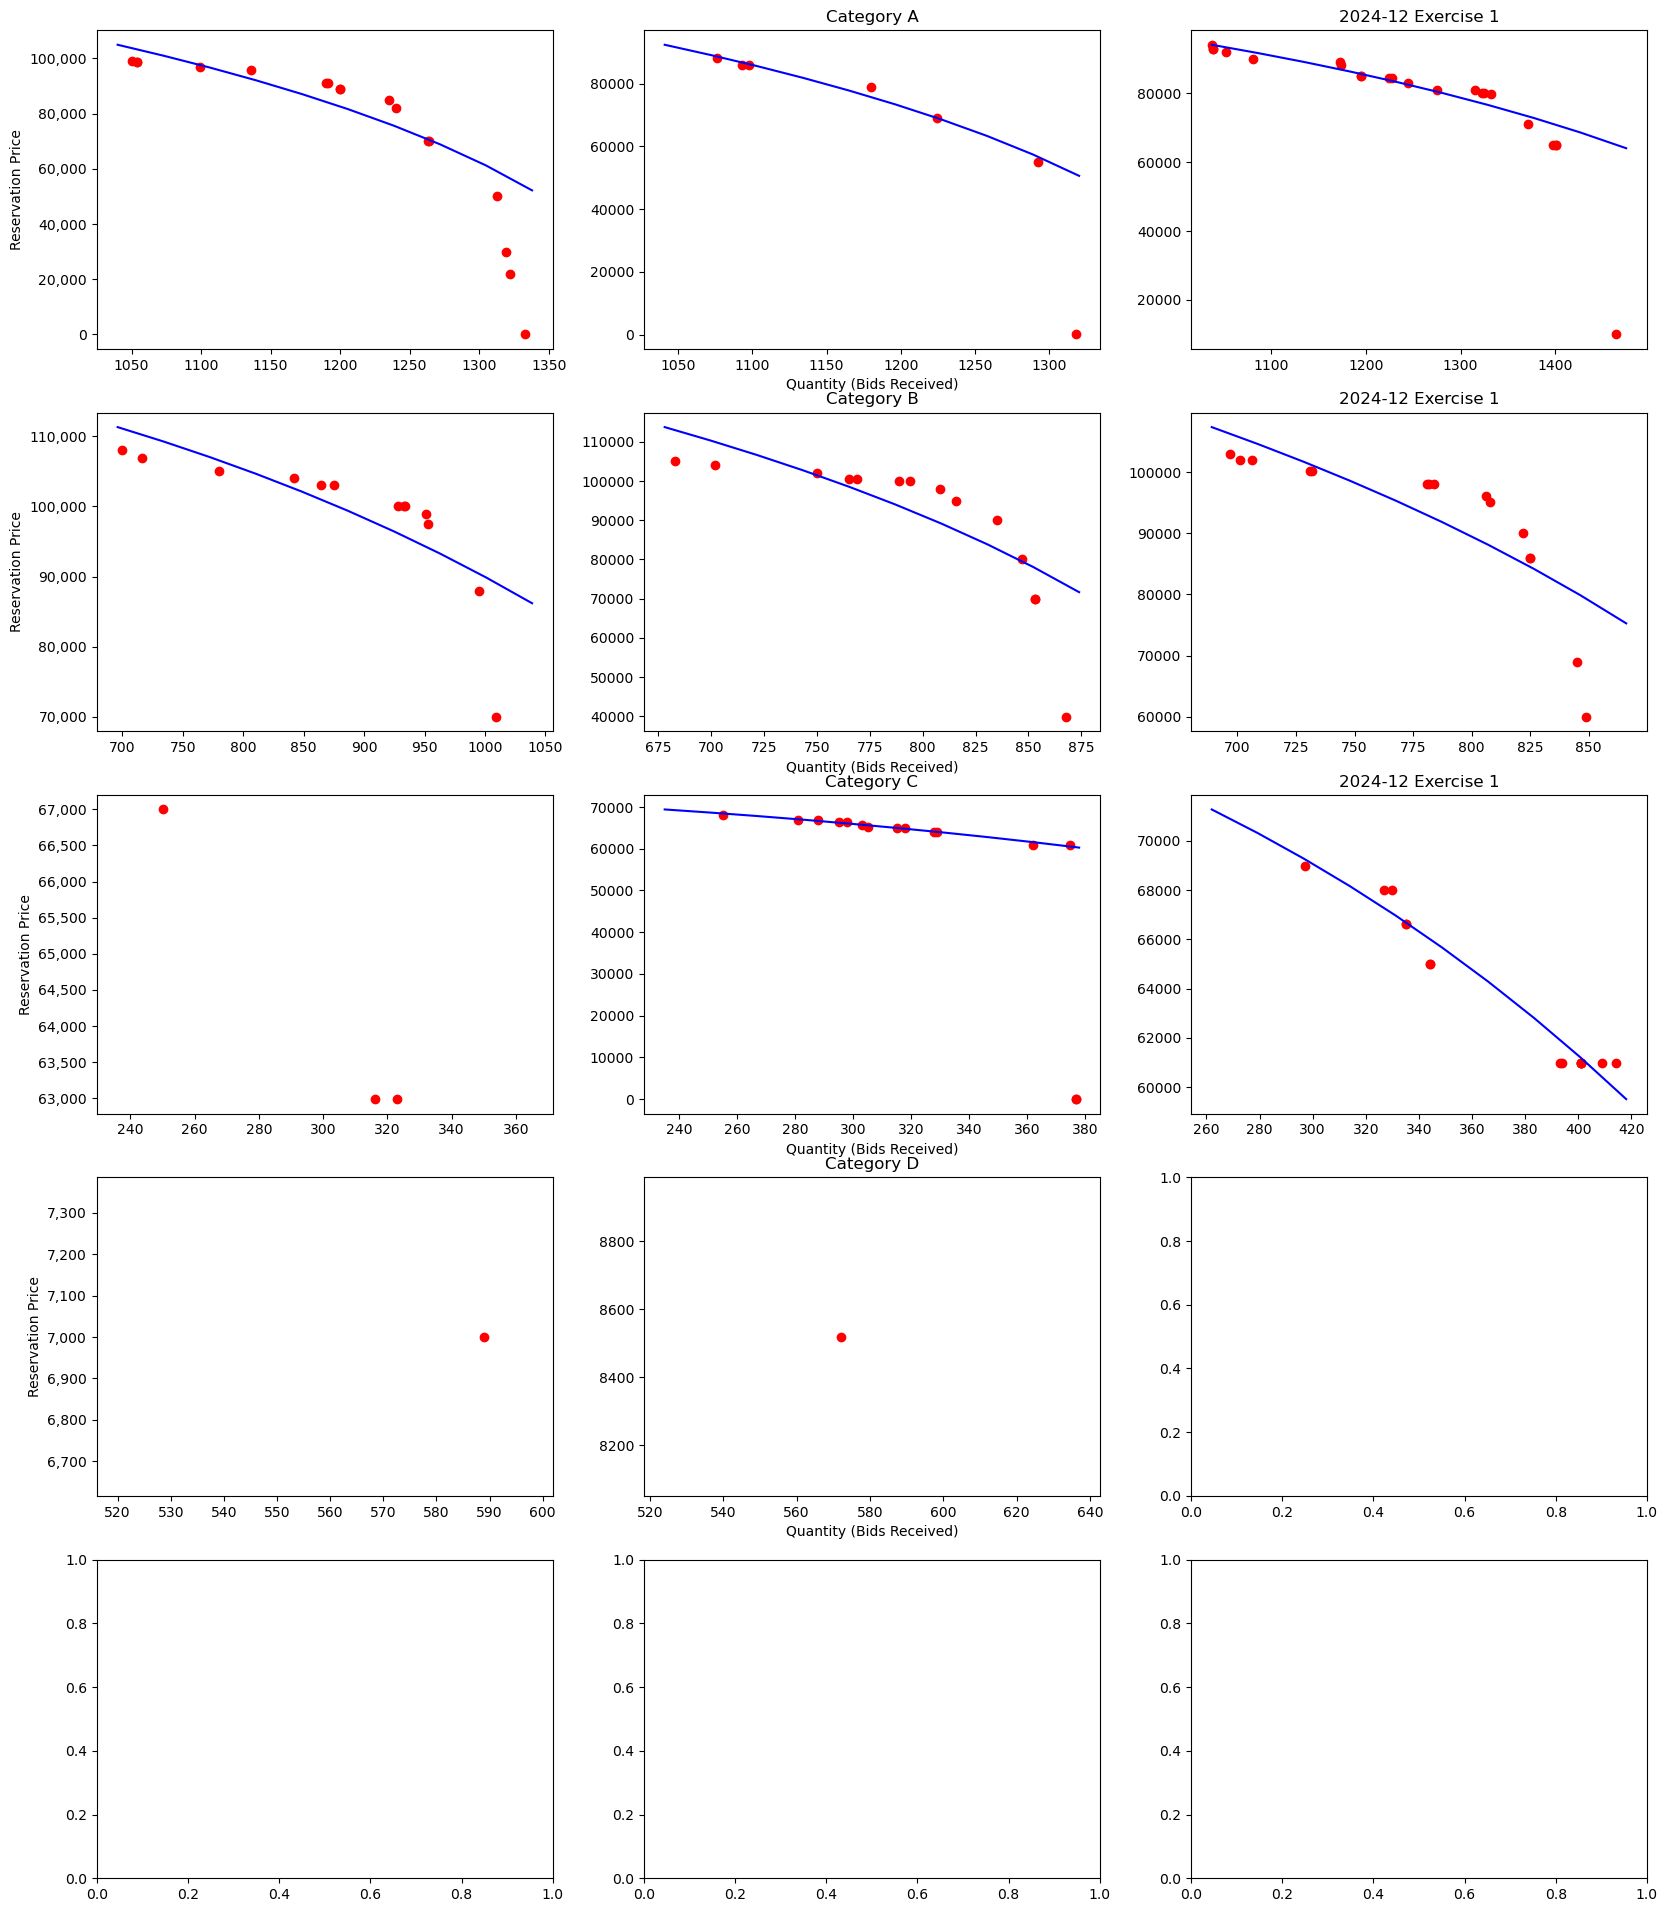

interactive(children=(SelectionSlider(description='Month/Exercise:', index=81, options=('2018-11/2', '2018-12/…

In [35]:
import ipywidgets as widgets
from ipywidgets import interact
from matplotlib.ticker import FuncFormatter

# Extract all 'month_exercise' and 'vehicle_category' and sort ascendingly
all_exercises = sorted(bidding_results['month_exercise'].unique())
all_categories = sorted(bidding_results['vehicle_category'].unique())

scatter_data = merged_realtime_status[merged_realtime_status['reservation_price'] > 0].groupby(['month', 'exercise', 'vehicle_category'])

def plot_demand_curve(selected_exercise):
    k = all_exercises.index(selected_exercise)
    selected_exercises = [all_exercises[k-2], all_exercises[k-1], all_exercises[k]]

    fig, axes = plt.subplots(len(all_categories), 3, figsize=(20, 24), sharex=False, sharey=False)
    axes = axes.flatten()

    # Collect y-limits for each row
    y_limits = [[float('inf'), float('-inf')] for _ in range(len(all_categories))]

    for i, ax in enumerate(axes):
        exercise_index = i % 3
        category_index = i // 3
        
        month_exercise = selected_exercises[exercise_index]
        month, exercise = month_exercise.split('/')
        vehicle_category = all_categories[category_index]
        
        matched_bidding_results = bidding_results_i.loc[month, exercise, vehicle_category]
        
        # Check if the key exists in fitted_coefficients
        if (month, exercise, vehicle_category) in fitted_coefficients.index:
            matched_coefficients = fitted_coefficients.loc[month, exercise, vehicle_category]
        else:
            matched_coefficients = None

        filtered_status = scatter_data.get_group((month, exercise, vehicle_category))

        # Extract relevant values
        quota = matched_bidding_results['quota']
        bids_received = matched_bidding_results['bids_received']
        y_hat_0 = matched_bidding_results.get('y_hat_0', None)
        y_hat_1 = matched_bidding_results.get('y_hat_1', None)

        # Plot the demand curve if coefficients are available
        if matched_coefficients is not None:
            # Extract coefficients
            a = matched_coefficients['a']
            b = matched_coefficients['b']

            # Generate x and y values for the demand curve
            x_values = np.linspace(quota, bids_received, 10)
            y_values = np.sqrt(a * x_values ** 2 + b)

            # Plot the demand curve
            ax.plot(x_values, y_values, label='Demand Curve', color='blue')

        # Overlay scatter plot of reservation price against demand
        ax.scatter(filtered_status['demand'], filtered_status['reservation_price'], color='red', label='Reservation Price at Demand')

        # Add 5% padding on all sides
        x_padding = 0.05 * (bids_received - quota)
        ax.set_xlim(quota - x_padding, bids_received + x_padding)
        
        # Update y-limits for the current row based on scatter plot and y_hat values
        if not filtered_status.empty:
            scatter_min = filtered_status['reservation_price'].min()
            scatter_max = filtered_status['reservation_price'].max()
            if y_hat_0 is not None and y_hat_1 is not None:
                y_min = max(scatter_min, y_hat_1)
                y_max = min(scatter_max, y_hat_0)
                y_limits[category_index][0] = min(y_limits[category_index][0], y_min)
                y_limits[category_index][1] = max(y_limits[category_index][1], y_max)

        # Add labels and legend
        if exercise_index == 0:
            ax.set_ylabel('Reservation Price')
            ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))
        if exercise_index == 1:
            ax.set_xlabel('Quantity (Bids Received)')
            ax.set_title(f'Category {vehicle_category}')
        if exercise_index == 2:
            ax.set_title(f'{month} Exercise {exercise}')

    # Set y-limits for each row
    for i, ax in enumerate(axes):
        category_index = i // 3
        y_min, y_max = y_limits[category_index]
        if y_min != float('inf') and y_max != float('-inf'):
            y_padding = 0.05 * (y_max - y_min)
            ax.set_ylim(y_min - y_padding, y_max + y_padding)

    plt.tight_layout()

interact(plot_demand_curve, selected_exercise=widgets.SelectionSlider(options=all_exercises[2:], value=all_exercises[-1], description='Month/Exercise:'));